
# Data Structures & Algorithms – Group Assignment 2
### Group 9: 
- Sofie Appel (sofie.appel@colorado.edu)
- Isra Marcu (isra.marcu@colorado.edu)
- Abhirama Karthikeya Mullapudi (abhiramakarthikeya.mullapudi@colorado.edu)
- Erin Noonan (erin.noonan@colorado.edu)

### Installing and Importing Required Libraries

In [ ]:
%pip install pandas matplotlib wordcloud requests nltk ipytest


In [2]:
import re
import string
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from itertools import islice
from wordcloud import WordCloud
import requests
import nltk


# Q1 : Table of Contents (Tree Structure)

In this section, we implement a hierarchical **Table of Contents (TOC) tree** without using any external tree libraries.  
  


## 1. Data Source: ***Pattern Recognition and Machine Learning*** by Christopher M. Bishop  

**Book:** *Pattern Recognition and Machine Learning*  
**Author:** Christopher M. Bishop  
**Publisher:** Springer, 2006  
**ISBN:** 978-0-387-31073-2  

**Source for Table of Contents:**  
[https://www.microsoft.com/en-us/research/publication/pattern-recognition-machine-learning/](https://www.microsoft.com/en-us/research/publication/pattern-recognition-machine-learning/)

We will reconstruct the TOC hierarchy for the **first ten chapters** only, each containing 5 sections (sub-chapters) and 5 subsections(sub-sub-chapters), following the book’s structure.

---

## 2. Design Explanation

### 2.1. Tree Structure

We designed a hierarchical **Table of Contents (TOC)** tree that mirrors the structure of the book. Each node in the tree represents either a **chapter**, **subchapter**, or **sub-subchapter**, creating a natural hierarchy that matches how books are organized.

Our implementation uses two main classes. 
- The **`Node`** class represents individual sections, where each node contains a `title` string for the chapter or section name, a `children` list that holds all sub-sections, and a `parent` reference pointing back to the parent node. We included the parent reference primarily to simplify depth calculations, though it's not strictly necessary for the basic tree structure. 
- The **`Book`** class represents the entire TOC and serves as the main interface for interacting with the tree. It holds the root node (which stores the book title) and provides all the methods we need to build and query the structure, i.e. things like inserting new sections, displaying the TOC in different formats, and computing properties like depth and height.

### 2.2. Insertion Strategy

We implemented an `insert(path, title)` method that takes a path (list of indices) and a title string. For example, calling `insert([5, 3, 2], "Backpropagation Algorithm")` navigates to Chapter 3, then Subchapter 2, then creates or updates Sub-subchapter 5 with the given title.

One feature we added is **automatic placeholder creation**. If you try to insert something at path `[3, 2, 5]` but Chapter 3 only has one subchapter so far, the method automatically creates placeholder nodes (labeled "Untitled 2", "Untitled 3", etc.) to fill the gaps. This makes building the tree much more flexible, as you don't have to insert nodes in perfect sequential order. The insertion process is efficient with **O(d) time complexity**, where d is the depth of the path, since we only need to traverse down the specific path being inserted.

### 2.3. Traversal Method

We chose **Preorder Depth-First Search (DFS)** as our traversal strategy for both printing and searching operations. This was a deliberate choice because preorder visits a parent node before its children, which matches how we read a book's table of contents. We see "Chapter 3: Neural Networks" before you see "Section 3.1: Feedforward Networks". This traversal method ensures our TOC maintains the correct reading order throughout all operations. The time complexity is **O(n)** since every node is visited exactly once during a complete traversal.

### 2.4. Printing the Table of Contents

Our `print_toc(mode)` method displays the entire TOC in three different formats:
- **Plain mode**: Shows just the titles in order
- **Indented mode**: Adds visual hierarchy by indenting each level with spaces, making the structure immediately obvious
- **Numbered mode**: Prefixes each title with its full path number (like "3.2.5"), which is the standard format for technical books

We always print the book title at the top as a header, which gives context to the TOC. All three modes use the same preorder DFS traversal, so the **time complexity is O(n)**, i.e., we visit each node once and print it.

### 2.5. Searching for Content

We implemented a `search(keyword, print_results)` method that finds all nodes containing a given keyword. The search is case-insensitive and matches partial strings, so searching for "neural" will find "Neural Networks", "Convolutional Neural Networks", etc. By default, it prints formatted results showing the path, title, and depth of each match. But we also added a `print_results=False` option that returns the raw data as a list, which is useful if you want to process the results programmatically. Since we need to check every node's title, the **time complexity is O(n)**.

### 2.6. Deleting Nodes

Our `delete(path)` method removes a node at the specified path. We made sure to handle edge cases properly. If the path doesn't exist, it prints a clear error message instead of crashing. If you try to delete the root node (empty path), it explicitly rejects that since removing the book title wouldn't make sense.

One important behavior: if you delete a node that has children, all its descendants are deleted too. This is intentional because removing "Chapter 3" should also remove all its sections and subsections. The method navigates to the parent node following the path, then removes the target child. The **time complexity is O(d)** where d is the path depth, since we only traverse down to the target node.

### 2.7. Computing Tree Properties

We included two helper methods for analyzing the tree structure. The `depth(node_title)` method finds the first node matching a given title and returns its level **(root is 0, chapters are 1, etc.)**. In the worst case, if the node is at the very end of the tree or doesn't exist, we have to check every node, giving **O(n) time complexity**. The `height()` method calculates the maximum depth of the tree by recursively finding the height of all subtrees and taking the maximum. This requires visiting every node once, so it's also **O(n)**.

### 2.8. Structure Summary

Finally, we added a `structure_summary()` method that counts how many nodes exist at each level and displays a formatted report. This is really useful for verifying that our book meets the assignment requirements (10 chapters, 5 subchapters each, etc.). It does a single preorder traversal counting nodes at each depth level, with **O(n) time complexity**.

---

## 3. Implementation of Classes and Methods

In [3]:

#Table of Contents : Tree Structure Implementation

class Node:
    """A node representing a chapter, section, or subsection."""
    def __init__(self, title: str, parent=None):
        self.title = title
        self.children = []
        self.parent = parent

    def add_child(self, child_node):
        """Attach a new child to the current node."""
        self.children.append(child_node)
        child_node.parent = self


class Book:
    """Book class that manages the hierarchical TOC tree."""
    def __init__(self, title: str):
        self.root = Node(title)

    #Insert Method
    def insert(self, path, title):
        """
        Insert a title at the specified path.
        Example: [3, 2, 5] -> Chapter 3 → Subchapter 2 → Sub-subchapter 5
        """
        current = self.root

        # Traverse or create intermediate nodes as needed
        for level, index in enumerate(path):
            if index <= 0:
                raise ValueError("Path indices must be positive integers (1-based).")

            # Create placeholder nodes if path exceeds current children count
            while len(current.children) < index:
                placeholder_title = f"Untitled {len(current.children) + 1}"
                current.add_child(Node(placeholder_title))

            current = current.children[index - 1]

        # Assign the title to the final node
        current.title = title

    # ------------------------------------------------------------------
    # PRINT TOC METHOD
    # ------------------------------------------------------------------
    def print_toc(self, mode="plain"):
        """Display the TOC in plain, indented, or numbered mode."""
        if mode not in ["plain", "indented", "numbered"]:
            raise ValueError("Mode must be one of: 'plain', 'indented', 'numbered'")
        
        # Print book title as header
        print("=" * 60)
        print(self.root.title.upper())
        print("=" * 60)
        print()
        
        def pre_order_dfs(node, level=0, numbering=[]):
            
            if node != self.root:
                num_str = ".".join(map(str, numbering))
            
                if mode == "plain":
                    print(node.title)
                elif mode == "indented":
                    print("  " * level + f"{num_str} {node.title}")
                elif mode == "numbered":
                    num_str = ".".join(map(str, numbering))
                    print(f"{num_str} {node.title}")  
            
            for idx, child in enumerate(node.children, start=1):
                pre_order_dfs(child, level + 1, numbering + [idx])
        
        pre_order_dfs(self.root)

    # ------------------------------------------------------------------
    # DEPTH METHOD
    # ------------------------------------------------------------------
    def depth(self, node_title):
        """Return the depth of the first node matching the title."""
        def pre_order_dfs(node, level):
            if node.title == node_title:
                return level
            for child in node.children:
                d = pre_order_dfs(child, level + 1)
                if d != -1:
                    return d
            return -1

        return pre_order_dfs(self.root, 0)

    # ------------------------------------------------------------------
    # HEIGHT METHOD
    # ------------------------------------------------------------------
    def height(self):
        """Return the height of the tree (max depth from root)."""
        def pre_order_dfs_height(node):
            if not node.children:
                return 0
            return 1 + max(pre_order_dfs_height(child) for child in node.children)
        return pre_order_dfs_height(self.root)

    # ------------------------------------------------------------------
    # COUNT NODES AT EACH LEVEL AND PRINT STRUCTURE SUMMARY
    # ------------------------------------------------------------------
    def structure_summary(self):
        """
        Display a summary of the book structure with counts at each level.
        Level 0 = root (book title)
        Level 1 = chapters
        Level 2 = subchapters
        Level 3 = sub-subchapters, etc.
        """
        #Count the nodes in each level
        level_counts = {}
    
        def pre_order_dfs(node, level):
            if level not in level_counts:
                level_counts[level] = 0
            level_counts[level] += 1
            
            for child in node.children:
                pre_order_dfs(child, level + 1)
        
        pre_order_dfs(self.root, 0)
        
        # Print formatted summary
        labels = {0: "Book", 1: "Chapters", 2: "Subchapters", 3: "Sub-subchapters"}
        
        print("=" * 50)
        print("BOOK STRUCTURE SUMMARY")
        print("=" * 50)
        for level in sorted(level_counts.keys()):
            label = labels.get(level, f"Level {level}")
            print(f"{label}: {level_counts[level]}")
        print(f"Total Height: {self.height()}")
        print(f"Total Nodes: {sum(level_counts.values())}")
        print("=" * 50)

    # ------------------------------------------------------------------
    # SEARCH METHOD
    # ------------------------------------------------------------------
    def search(self, keyword, print_results=True):
        """
        Search for all nodes containing the keyword
        """
        results = []
        
        def pre_order_dfs(node, level, path):
            if keyword.lower() in node.title.lower():
                results.append((path.copy(), node.title, level))
            
            for idx, child in enumerate(node.children, start=1):
                pre_order_dfs(child, level + 1, path + [idx])
        
        pre_order_dfs(self.root, 0, [])
        
        # Print formatted results
        if print_results:
            labels = {0: "Book", 1: "Chapters", 2: "Subchapters", 3: "Sub-subchapters"}
            if not results:
                print(f"No results found for '{keyword}'")
                return
            
            print(f"\nSearch results for '{keyword}': {len(results)} found")
            print("-" * 50)
            for path, title, depth in results:
                
                print(f"{title} (depth: {labels.get(int(depth))})")
        else:
            return results
        
    # ------------------------------------------------------------------
    # DELETE METHOD
    # ------------------------------------------------------------------
    def delete(self, path):
        """
        Delete a node at the specified path. If the node has children, they will also be deleted. If the node does not exist, print an error.
        """
        if not path:
            print("Error: Cannot delete root node")
            return False
        
        # Navigate to the parent of the target node
        current = self.root
        
        try:
            # Traverse to parent
            for index in path[:-1]:
                if index <= 0 or index > len(current.children):
                    print(f"Error: Path {path} does not exist")
                    return False
                current = current.children[index - 1]
            
            # Check if final index is valid
            final_index = path[-1]
            if final_index <= 0 or final_index > len(current.children):
                print(f"Error: Path {path} does not exist")
                return False
            
            # Delete the node
            deleted_node = current.children[final_index - 1]
            current.children.pop(final_index - 1)
            print(f"Successfully deleted: '{deleted_node.title}'")
            return True
            
        except Exception as e:
            print(f"Error: Could not delete node at {path}")
            return False


## 4. Building the Table of Contents

We construct the TOC using a dictionary-based approach. This structure contains 10 chapters, each with 5 sections, and each section with 5 subsections, meeting all assignment requirements. The dictionary format makes it easy to add or modify chapters without worrying about order, since we sort the keys when building the tree.

In [4]:
# Create the Book object
book = Book("Pattern Recognition and Machine Learning")

# Dictionary-based structure (order doesn't matter!)
book_structure = {
    "1": {
        "title": "Introduction",
        "sections": {
            "1": "Machine Learning Fundamentals",
            "2": "Probability Theory",
            "3": "Model Selection and Bias-Variance Tradeoff",
            "4": "Decision Theory",
            "5": "Information Theory"
        }
    },
    "2": {
        "title": "Probability Distributions",
        "sections": {
            "1": "Binary and Discrete Distributions",
            "2": "Gaussian Distribution",
            "3": "Exponential Family",
            "4": "Nonparametric Methods",
            "5": "Conjugate Priors and Bayesian Inference"
        }
    },
    "3": {
        "title": "Linear Models for Regression",
        "sections": {
            "1": "Least Squares and Maximum Likelihood",
            "2": "Regularization and Ridge Regression",
            "3": "Bayesian Linear Regression",
            "4": "Basis Function Methods",
            "5": "Evidence Approximation and Model Comparison"
        }
    },
    "4": {
        "title": "Linear Models for Classification",
        "sections": {
            "1": "Discriminant Functions",
            "2": "Probabilistic Generative Models",
            "3": "Probabilistic Discriminative Models",
            "4": "Logistic Regression and Softmax",
            "5": "Iterative Reweighted Least Squares"
        }
    },
    "5": {
        "title": "Neural Networks",
        "sections": {
            "1": "Feed-Forward Network Architectures",
            "2": "Backpropagation Algorithm",
            "3": "Error Functions and Regularization",
            "4": "Mixture Density Networks",
            "5": "Bayesian Neural Networks"
        }
    },
    "6": {
        "title": "Kernel Methods",
        "sections": {
            "1": "Dual Representations",
            "2": "Constructing Kernels",
            "3": "Radial Basis Function Networks",
            "4": "Gaussian Processes for Regression",
            "5": "Gaussian Processes for Classification"
        }
    },
    "7": {
        "title": "Sparse Kernel Machines",
        "sections": {
            "1": "Support Vector Machines for Classification",
            "2": "Maximum Margin Classifiers",
            "3": "Relevance Vector Machines",
            "4": "Support Vector Machines for Regression",
            "5": "Computational Complexity and Sparsity"
        }
    },
    "8": {
        "title": "Graphical Models",
        "sections": {
            "1": "Bayesian Networks",
            "2": "Conditional Independence",
            "3": "Markov Random Fields",
            "4": "Inference in Graphical Models",
            "5": "Factor Graphs and Sum-Product Algorithm"
        }
    },
    "9": {
        "title": "Mixture Models and EM",
        "sections": {
            "1": "K-Means Clustering",
            "2": "Gaussian Mixture Models",
            "3": "Expectation-Maximization Algorithm",
            "4": "EM for Bayesian Linear Regression",
            "5": "Latent Variable Models and Applications"
        }
    },
    "10": {
        "title": "Approximate Inference",
        "sections": {
            "1": "Variational Inference",
            "2": "Variational Bayes",
            "3": "Expectation Propagation",
            "4": "Laplace Approximation",
            "5": "Monte Carlo Methods"
        }
    }
}

# Standard sub-subsections (same for all sections)
sub_subsections = [
    "Introduction and Motivation",
    "Mathematical Foundations",
    "Core Concepts and Methods",
    "Applications and Examples",
    "Summary and Extensions"
]

# Build the table of contents
for chapter_num in sorted(book_structure.keys(), key=int):
    chapter = book_structure[chapter_num]
    
    # Insert main chapter
    book.insert([int(chapter_num)], chapter["title"])
    
    # Insert sections
    for section_num in sorted(chapter["sections"].keys(), key=int):
        section_title = chapter["sections"][section_num]
        book.insert([int(chapter_num), int(section_num)], section_title)
        
        # Insert sub-subsections
        for subsection_idx, subsection_title in enumerate(sub_subsections, start=1):
            book.insert([int(chapter_num), int(section_num), subsection_idx], subsection_title)

## 5. Showcasing/Testing Table of Contents Tree Functionality

We demonstrate the key operations of our TOC tree implementation, including different printing modes, insertion with automatic placeholder creation, depth and height calculations, node deletion, and structure summary statistics.

### 5.1. Printing Modes

##### 5.1.1. Plain Mode

In [5]:
book.print_toc(mode = "plain")

PATTERN RECOGNITION AND MACHINE LEARNING

Introduction
Machine Learning Fundamentals
Introduction and Motivation
Mathematical Foundations
Core Concepts and Methods
Applications and Examples
Summary and Extensions
Probability Theory
Introduction and Motivation
Mathematical Foundations
Core Concepts and Methods
Applications and Examples
Summary and Extensions
Model Selection and Bias-Variance Tradeoff
Introduction and Motivation
Mathematical Foundations
Core Concepts and Methods
Applications and Examples
Summary and Extensions
Decision Theory
Introduction and Motivation
Mathematical Foundations
Core Concepts and Methods
Applications and Examples
Summary and Extensions
Information Theory
Introduction and Motivation
Mathematical Foundations
Core Concepts and Methods
Applications and Examples
Summary and Extensions
Probability Distributions
Binary and Discrete Distributions
Introduction and Motivation
Mathematical Foundations
Core Concepts and Methods
Applications and Examples
Summary and E

##### 5.1.2. Indented Mode

In [6]:
book.print_toc(mode = "indented")

PATTERN RECOGNITION AND MACHINE LEARNING

  1 Introduction
    1.1 Machine Learning Fundamentals
      1.1.1 Introduction and Motivation
      1.1.2 Mathematical Foundations
      1.1.3 Core Concepts and Methods
      1.1.4 Applications and Examples
      1.1.5 Summary and Extensions
    1.2 Probability Theory
      1.2.1 Introduction and Motivation
      1.2.2 Mathematical Foundations
      1.2.3 Core Concepts and Methods
      1.2.4 Applications and Examples
      1.2.5 Summary and Extensions
    1.3 Model Selection and Bias-Variance Tradeoff
      1.3.1 Introduction and Motivation
      1.3.2 Mathematical Foundations
      1.3.3 Core Concepts and Methods
      1.3.4 Applications and Examples
      1.3.5 Summary and Extensions
    1.4 Decision Theory
      1.4.1 Introduction and Motivation
      1.4.2 Mathematical Foundations
      1.4.3 Core Concepts and Methods
      1.4.4 Applications and Examples
      1.4.5 Summary and Extensions
    1.5 Information Theory
      1.5.1 Introducti

##### 5.1.2. Numbered Mode

In [7]:
book.print_toc(mode = "numbered")

PATTERN RECOGNITION AND MACHINE LEARNING

1 Introduction
1.1 Machine Learning Fundamentals
1.1.1 Introduction and Motivation
1.1.2 Mathematical Foundations
1.1.3 Core Concepts and Methods
1.1.4 Applications and Examples
1.1.5 Summary and Extensions
1.2 Probability Theory
1.2.1 Introduction and Motivation
1.2.2 Mathematical Foundations
1.2.3 Core Concepts and Methods
1.2.4 Applications and Examples
1.2.5 Summary and Extensions
1.3 Model Selection and Bias-Variance Tradeoff
1.3.1 Introduction and Motivation
1.3.2 Mathematical Foundations
1.3.3 Core Concepts and Methods
1.3.4 Applications and Examples
1.3.5 Summary and Extensions
1.4 Decision Theory
1.4.1 Introduction and Motivation
1.4.2 Mathematical Foundations
1.4.3 Core Concepts and Methods
1.4.4 Applications and Examples
1.4.5 Summary and Extensions
1.5 Information Theory
1.5.1 Introduction and Motivation
1.5.2 Mathematical Foundations
1.5.3 Core Concepts and Methods
1.5.4 Applications and Examples
1.5.5 Summary and Extensions
2 Prob

### 5.2. Summary of the Table of Contents

In [8]:
book.structure_summary()

BOOK STRUCTURE SUMMARY
Book: 1
Chapters: 10
Subchapters: 50
Sub-subchapters: 250
Total Height: 3
Total Nodes: 311


### 5.3. Calculating Depth of Nodes

In [9]:

print("\n" + "="*70)
print("DEPTH CALCULATION - Finding node levels")
print("="*70)

test_nodes = ["Pattern Recognition and Machine Learning", "Neural Networks", "Variational Inference", "Core Concepts and Methods", "Nonexistent Node"]
for node in test_nodes:
    depth = book.depth(node)
    if depth == -1:
        print(f"'{node}': Not found (depth = -1)")
    else:
        print(f"'{node}': depth = {depth}")


DEPTH CALCULATION - Finding node levels
'Pattern Recognition and Machine Learning': depth = 0
'Neural Networks': depth = 1
'Variational Inference': depth = 2
'Core Concepts and Methods': depth = 3
'Nonexistent Node': Not found (depth = -1)


### 5.4. Calculating Height of the Tree

In [10]:
print("\n" + "="*70)
print("HEIGHT CALCULATION - Maximum tree depth")
print("="*70)

print(f"Tree height: {book.height()}")
print(f"(Deepest path goes from root → chapter → section → subsection)")


HEIGHT CALCULATION - Maximum tree depth
Tree height: 3
(Deepest path goes from root → chapter → section → subsection)


### 5.5. Searching for Keywords

In [11]:
print("\n" + "="*70)
print("6. SEARCH FUNCTIONALITY - Finding content by keyword")
print("="*70)

book.search("inference")


6. SEARCH FUNCTIONALITY - Finding content by keyword

Search results for 'inference': 4 found
--------------------------------------------------
Conjugate Priors and Bayesian Inference (depth: Subchapters)
Inference in Graphical Models (depth: Subchapters)
Approximate Inference (depth: Chapters)
Variational Inference (depth: Subchapters)


### 5.6. Insertion
We demonstrate insertion (including automatic placeholder creation) on a new test book.

In [12]:
# Create a book
test_book = Book("Introduction to Algorithms")

print("="*60)
print("INSERTION")
print("="*60)

# Basic insertion
print("\n1. Basic sequential insertion:")
test_book.insert([1], "Sorting Algorithms")
test_book.insert([1, 1], "Bubble Sort")
test_book.insert([1, 2], "Quick Sort")
test_book.insert([1, 3], "Merge Sort")
print("Inserted Chapter 1 with 3 sections")

# Insertion with gap (creates placeholders)
print("\n2. Insertion with gap (automatic placeholder creation):")
test_book.insert([1, 6], "Heap Sort")  # Will create placeholders at [1,4] and [1,5]
print("Inserted at [1, 6]. Placeholders created at [1, 4] and [1, 5]")

# Insert another chapter
print("\n3. Inserting Chapter 2:")
test_book.insert([2], "Graph Algorithms")
test_book.insert([2, 1], "BFS")
test_book.insert([2, 2], "DFS")
print("Inserted Chapter 2 with 2 sections")

# Insert nested subsections
print("\n4. Inserting nested subsections:")
test_book.insert([2, 1, 1], "BFS on Trees")
test_book.insert([2, 1, 2], "BFS on Graphs")
print("Inserted subsections under BFS")

print("\nCurrent TOC structure:")
test_book.print_toc(mode="indented")


INSERTION

1. Basic sequential insertion:
Inserted Chapter 1 with 3 sections

2. Insertion with gap (automatic placeholder creation):
Inserted at [1, 6]. Placeholders created at [1, 4] and [1, 5]

3. Inserting Chapter 2:
Inserted Chapter 2 with 2 sections

4. Inserting nested subsections:
Inserted subsections under BFS

Current TOC structure:
INTRODUCTION TO ALGORITHMS

  1 Sorting Algorithms
    1.1 Bubble Sort
    1.2 Quick Sort
    1.3 Merge Sort
    1.4 Untitled 4
    1.5 Untitled 5
    1.6 Heap Sort
  2 Graph Algorithms
    2.1 BFS
      2.1.1 BFS on Trees
      2.1.2 BFS on Graphs
    2.2 DFS


### 5.7. Deletion

We demonstrate deletion of nodes on the book created above

In [13]:
print("\n" + "="*60)
print("DELETION")
print("="*60)

# Delete a leaf node
print("\n1. Deleting a leaf node (Quick Sort at [1, 2]):")
test_book.delete([1, 2])

print("\nTOC after deletion:")
test_book.print_toc(mode="indented")

# Delete a node with children
print("\n\n2. Deleting a node with children (BFS at [2, 1]):")
test_book.delete([2, 1])  # This will also delete [2,1,1] and [2,1,2]

print("\nTOC after deleting node with children:")
test_book.print_toc(mode="indented")

# Try deleting non-existent node
print("\n\n3. Error handling - deleting non-existent path [5, 1]:")
test_book.delete([5, 1])

# Try deleting with invalid index
print("\n\n4. Error handling - deleting with invalid index [0]:")
test_book.delete([0])



DELETION

1. Deleting a leaf node (Quick Sort at [1, 2]):
Successfully deleted: 'Quick Sort'

TOC after deletion:
INTRODUCTION TO ALGORITHMS

  1 Sorting Algorithms
    1.1 Bubble Sort
    1.2 Merge Sort
    1.3 Untitled 4
    1.4 Untitled 5
    1.5 Heap Sort
  2 Graph Algorithms
    2.1 BFS
      2.1.1 BFS on Trees
      2.1.2 BFS on Graphs
    2.2 DFS


2. Deleting a node with children (BFS at [2, 1]):
Successfully deleted: 'BFS'

TOC after deleting node with children:
INTRODUCTION TO ALGORITHMS

  1 Sorting Algorithms
    1.1 Bubble Sort
    1.2 Merge Sort
    1.3 Untitled 4
    1.4 Untitled 5
    1.5 Heap Sort
  2 Graph Algorithms
    2.1 DFS


3. Error handling - deleting non-existent path [5, 1]:
Error: Path [5, 1] does not exist


4. Error handling - deleting with invalid index [0]:
Error: Path [0] does not exist


False

---

## 6. Complexity Analysis

We analyzed the time and space complexity of each operation in our TOC tree implementation. Since most of our operations involve tree traversal, the complexities depend on either the depth of a specific path (d), the total number of nodes (n), or the height of the tree (h).

- **Insert Operation:**  
Inserting a new node requires traversing down the tree following the path indices we provide. Along the way, we might need to create placeholder nodes at each level if they don't exist yet. The time complexity is **O(d)** where d is the depth of the path, since we only visit nodes along that specific path. The space complexity is **O(d)** for the recursion stack during traversal.

- **Delete Operation:**  
Deleting a node works similarly to insertion. We navigate to the parent node by following the path indices. Once we reach the target's parent, the actual deletion operation is just removing an element from a list, which is O(1). Overall, the time complexity is **O(d)** where d is the path depth. The space complexity is **O(d)** for storing the path during traversal.

- **Print TOC Operation:**  
Printing the table of contents uses preorder DFS traversal to visit every node in the tree exactly once. Each node is printed as we visit it, whether in plain, indented, or numbered format. The time complexity is **O(n)** where n is the total number of nodes. The space complexity is **O(h)** where h is the height, due to the recursion stack that can grow as deep as the tallest branch.

- **Depth Calculation:**  
Finding the depth of a specific node requires searching through the tree using preorder DFS until we find a title match. In the best case, if the target is near the root, we might find it immediately in O(1) time. However, in the worst case, we might need to visit every single node before finding it (or determining it doesn't exist), giving us **O(n)** time complexity. The space complexity is **O(h)** for the recursion stack.

- **Height Calculation:**  
Computing the tree's height requires visiting every node once to find the maximum depth. We recursively calculate the height of all subtrees and take the maximum value. The time complexity is **O(n)** since we must examine every node. The space complexity is **O(h)** for the recursion stack in the worst case.

- **Search Operation:**  
Our search method must check every node's title for a keyword match, which means we perform a complete tree traversal using preorder DFS. There's no way around visiting all nodes since any of them could contain the keyword. The time complexity is **O(n)**. For space complexity, we use **O(h)** for the recursion stack, plus **O(k)** to store the k matching results we find.

- **Structure Summary:**  
This method performs a single preorder DFS traversal while counting nodes at each level. Since each node is visited exactly once and we just increment counters, the time complexity is **O(n)**. The space complexity is **O(h)** for the recursion stack, plus **O(L)** where L is the number of distinct levels (which is bounded by h).

Overall, our implementation achieves good efficiency for a tree-based structure. The operations that modify single paths (insert and delete) are particularly fast at O(d), while operations that need to examine the entire tree (print, search, height) naturally take O(n) time. All operations maintain reasonable space usage, primarily limited by the tree's height rather than its total size.

---

# Q2. Letters & Words Analysis

## 1. Data Source: ***The Adventures of Sherlock Holmes*** by Sir Arthur Conan Doyle

**Book:** *The Adventures of Sherlock Holmes*  
**Author:** Sir Arthur Conan Doyle
**Source:** [Project Gutenberg](https://www.gutenberg.org/files/1661/1661-0.txt)  
**License:** Public Domain

We perform a text analysis on "The Adventures of Sherlock Holmes" by Sir Arthur Conan Doyle, obtained from Project Gutenberg. Our analysis pipeline consists of several stages, each designed to extract different linguistic insights from the text.

---

## 2. Data Acquisition
We download the text directly from Project Gutenberg using Python's `requests` library. The URL points to the UTF-8 encoded plain text version of the book. We keep two copies of the text: one for preprocessing and analysis, and an unmodified `original_text` copy that we'll use later for sentence-level analysis where we need to preserve original capitalization and punctuation.

In [14]:
# Download the text directly from Project Gutenberg
url = "https://www.gutenberg.org/files/1661/1661-0.txt"
text = requests.get(url).text

# Keep an unmodified copy for reference (used later for sentence analysis)
original_text = text

print("DATA LOADED SUCCESSFULLY")
print(f"Original text length: {len(text)} characters")

DATA LOADED SUCCESSFULLY
Original text length: 593731 characters


---

## 3. Text Preprocessing


Our `text_clean()` function performs several cleaning steps to prepare the text for analysis. First, we convert everything to lowercase to ensure consistent counting (so "The" and "the" are treated as the same word). We then remove all newlines (\n) and carriage returns (\r), replacing them with spaces to create a continuous text flow.

Since our text comes from Project Gutenberg, it includes licensing information and headers that aren't part of the actual novel. We use the triple asterisk (`***`) markers to split the document and extract only the actual book content (section 2). We also remove Roman numerals that mark chapter divisions, as these don't contribute meaningful content.

For punctuation handling, we use a regular expression that removes everything except lowercase letters, apostrophes, and spaces. This means contractions like "don't" and "Holmes's" stay intact, which is important for preserving meaning. Finally, we normalize whitespace by removing multiple consecutive spaces.


In [15]:
def text_clean(text):
    """
    Clean and preprocess text for analysis.
    
    Parameters: text: raw text string
    
    Returns : cleaned text string
    """
    print("\n" + "="*70)
    print("PREPROCESSING STEPS")
    print("="*70)
    print(f"Original text length: {len(text)} characters")
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove all carriage returns and newlines
    text = text.replace("\n", " ").replace("\r", " ")
    
    # Remove Project Gutenberg header and footer, if present
    # The content is between the second and third set of "***"
    
    if "***" in text:
        content_breakout = text.split("***")
        if len(content_breakout) >= 3:
            text = content_breakout[2]
            print("Removed Project Gutenberg header/footer")
        else:
            # Fallback if split didn't give expected parts
            print("No full Project Gutenberg header/footer found (split by '***' did not produce 3 parts); skipping removal")
    else:
        print("No Project Gutenberg markers ('***') found; skipping header/footer removal")
    
    
    # Remove Roman numerals (chapter numbers)
    roman_num = ["xii.", " xi.", " ix.", " x.", "viii.", "vii.", " vi.", 
                 "iii.", "ii.", " i.", " iv.", " v."]
    for ch in roman_num:
        text = text.replace(ch, "")
    print("Removed Roman numerals")
    
    # Remove punctuation, digits, and special characters
    # Keep apostrophes inside words (e.g., "don't" remains intact)
    text = re.sub(r"[^a-z'\s]", " ", text)
    print("Removed punctuation, digits, special characters (kept apostrophes)")
    
    # Remove multiple consecutive spaces
    spaces = ["     ", "    ", "   ", "  "]
    for sp in spaces:
        text = text.replace(sp, " ").strip()
    print("Normalized whitespace")
    
    print(f"Cleaned text length: {len(text)} characters")
    
    return text

# Clean the text
text = text_clean(text)


PREPROCESSING STEPS
Original text length: 593731 characters
Removed Project Gutenberg header/footer
Removed Roman numerals
Removed punctuation, digits, special characters (kept apostrophes)
Normalized whitespace
Cleaned text length: 537189 characters


---

## 4. Tokenization
We implement a custom tokenization function that splits text into individual words. Rather than using built-in `split()` methods, we manually parse character-by-character to demonstrate our understanding of the tokenization process. The function iterates through each character, building up words until it encounters a space, at which point it adds the complete word to our tokens list. This gives us full control over the tokenization logic and aligns with the assignment's requirement to implement our own simple tokenization.


In [16]:
def tokenize(text):
    """
    Tokenize text by whitespace using manual character-by-character parsing.
    
    Returns: list of tokens (words)
    """
    steps = len(text)
    word = ""
    tokens = []
    
    for i in range(steps):
        if i == (steps - 1):
            word = word + text[i]
            tokens.append(word)
        elif text[i] == " ":
            if word:  # Only append non-empty words
                tokens.append(word)
            word = ""
        else:
            word = word + text[i]
    
    return tokens

print("\n" + "="*70)
print("TOKENIZATION")
print("="*70)
tokens = tokenize(text)
print(f"Total tokens: {len(tokens)}")
print(f"Sample tokens: {tokens[:20]}")


TOKENIZATION
Total tokens: 105811
Sample tokens: ['the', 'adventures', 'of', 'sherlock', 'holmes', 'by', 'arthur', 'conan', 'doyle', 'contents', 'a', 'scandal', 'in', 'bohemia', 'the', 'red', 'headed', 'league', 'a', 'case']


---

## 5. Stopwords Removal
Stopwords are common words like "the", "is", "and", "to" that appear frequently but don't carry much meaning for content analysis. We use NLTK's English stopwords list to filter these out. This preprocessing step is crucial because it allows us to focus on the meaningful content words that actually tell us what the text is about. We print before and after token counts to show how many words were removed.


In [17]:
def filter_stopwords(tokens):
    """
    Remove common English stopwords from token list.
    Uses NLTK stopwords list (as permitted by assignment).
    
    Returns: filtered token list
    """
    print("\n" + "="*70)
    print("STOPWORD REMOVAL")
    print("="*70)
    print(f"Token count before stopword removal: {len(tokens)}")
    
    # Download and load NLTK stopwords
    nltk.download('stopwords', quiet=True)
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    print(f"Token count after stopword removal: {len(filtered_tokens)}")
    print(f"Tokens removed: {len(tokens) - len(filtered_tokens)}")
    print(f"Sample filtered tokens (tokens that are kept in): {filtered_tokens[:20]}")
    print(f"Sample removed tokens: {[word for word in tokens if word in stop_words][:20]}")
    
    return filtered_tokens

filtered_tokens = filter_stopwords(tokens)


STOPWORD REMOVAL
Token count before stopword removal: 105811
Token count after stopword removal: 47104
Tokens removed: 58707
Sample filtered tokens (tokens that are kept in): ['adventures', 'sherlock', 'holmes', 'arthur', 'conan', 'doyle', 'contents', 'scandal', 'bohemia', 'red', 'headed', 'league', 'case', 'identity', 'boscombe', 'valley', 'mystery', 'five', 'orange', 'pips']
Sample removed tokens: ['the', 'of', 'by', 'a', 'in', 'the', 'a', 'of', 'the', 'the', 'the', 'with', 'the', 'the', 'of', 'the', 'the', 'of', 'the', 'the']


---

## 6. Letter Frequency Analysis
We extract every individual letter from our cleaned text and count how often each appears. Using Python's `Counter` class, we create frequency counts for all 26 letters. We then convert this to a pandas DataFrame and calculate proportions (each letter's count divided by total letters) to see the relative frequency distribution.

The bar chart visualization shows which letters Conan Doyle used most frequently. In English text, we typically expect letters like 'e', 't', 'a', 'o', and 'i' to be most common, and this analysis confirms whether our text follows that pattern.



LETTER FREQUENCY ANALYSIS (a-z)
Letter frequency statistics (In Descending Order):

Letter  Count  Proportion
     e  53082    0.123052
     t  38980    0.090361
     a  35125    0.081425
     o  33475    0.077600
     i  30073    0.069714
     h  29048    0.067338
     n  28641    0.066394
     s  27159    0.062959
     r  24502    0.056799
     d  18520    0.042932
     l  17145    0.039745
     u  13074    0.030307
     m  11787    0.027324
     w  11266    0.026116
     c  10500    0.024341
     y   9431    0.021862
     f   8975    0.020805
     g   7888    0.018286
     p   6798    0.015759
     b   6363    0.014750
     v   4436    0.010283
     k   3542    0.008211
     x    541    0.001254
     j    452    0.001048
     q    427    0.000990
     z    149    0.000345


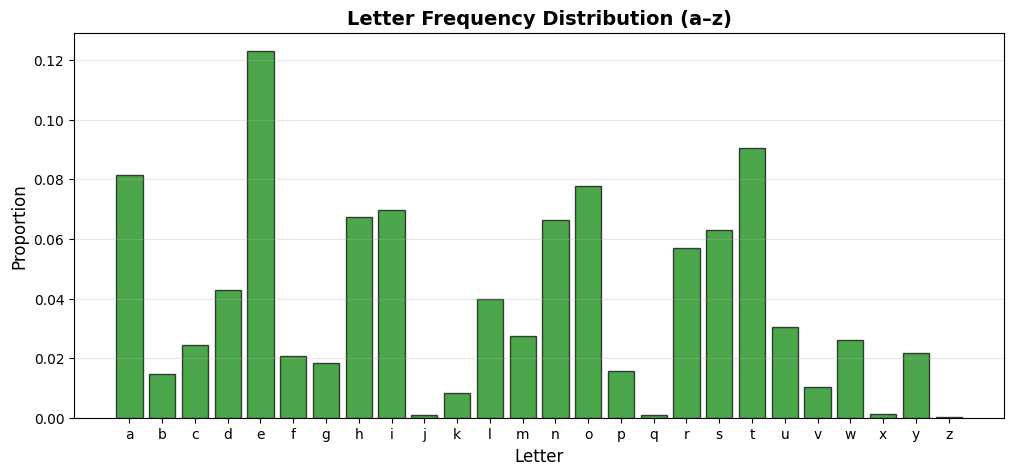

In [18]:
print("\n" + "="*70)
print("LETTER FREQUENCY ANALYSIS (a-z)")
print("="*70)

# Extract all letters from cleaned text
letters = re.findall(r"[a-z]", text)
letter_counts = Counter(letters)

# Create DataFrame with counts and proportions
df_letters = pd.DataFrame(letter_counts.items(), 
                          columns=["Letter", "Count"]).sort_values(by="Letter")
df_letters["Proportion"] = df_letters["Count"] / df_letters["Count"].sum()

print("Letter frequency statistics (In Descending Order):\n")
print(df_letters.sort_values(by = "Count", ascending=False).to_string(index = False))

# Visualize letter frequencies
plt.figure(figsize=(12, 5))
plt.bar(df_letters["Letter"], df_letters["Proportion"], 
        color="green", edgecolor="black", alpha=0.7)
plt.title("Letter Frequency Distribution (a–z)", fontsize=14, fontweight='bold')
plt.xlabel("Letter", fontsize=12)
plt.ylabel("Proportion", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

---


## 7. Word Frequency Analysis

After removing stopwords, we count how often each meaningful word appears. We extract the top 40 most frequent words and display them in both tabular and visual formats. The bar chart gives us a clear ranking of word frequencies, making it easy to see which words dominate the text.

Also, We create two word clouds: one showing all frequent words with size proportional to frequency, and another limited to exactly the top 40 words. We set `collocations=False` to prevent the WordCloud library from automatically creating its own bigrams, since we're analyzing those separately. These visualizations quickly reveal the main themes and topics in the text, and we'd expect to see character names like "Holmes" and "Watson" prominently featured.




WORD FREQUENCY ANALYSIS (After Stopword Removal)
Top 40 most frequent words:


,Word,Count
0,said,486
1,upon,465
2,holmes,462
3,one,376
4,would,327
5,man,305
6,could,286
7,mr,275
8,little,269
9,see,229


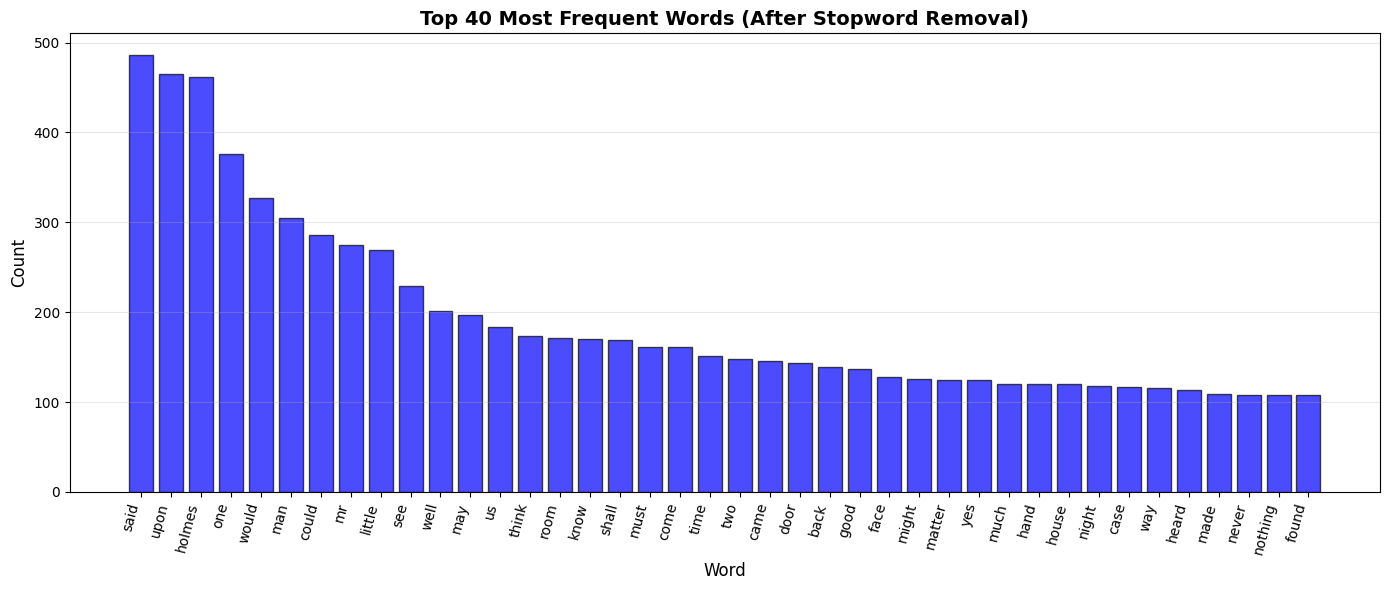

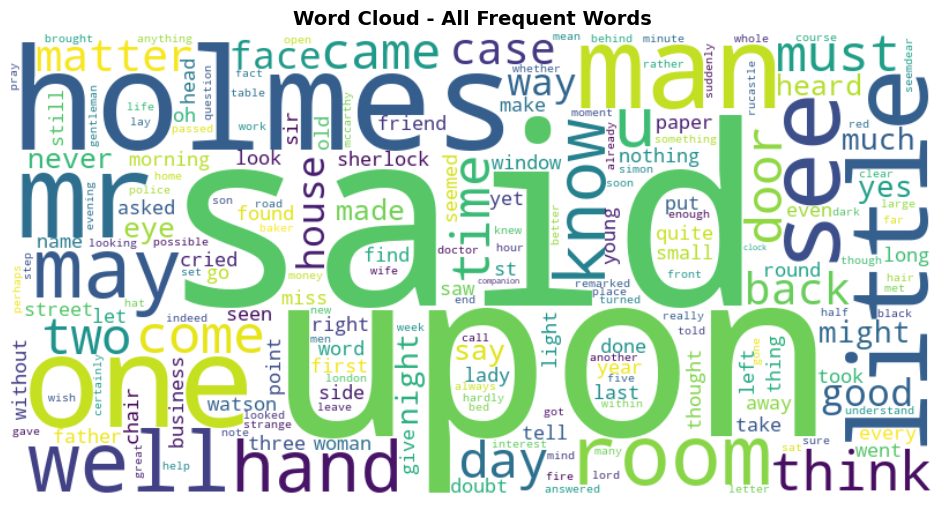

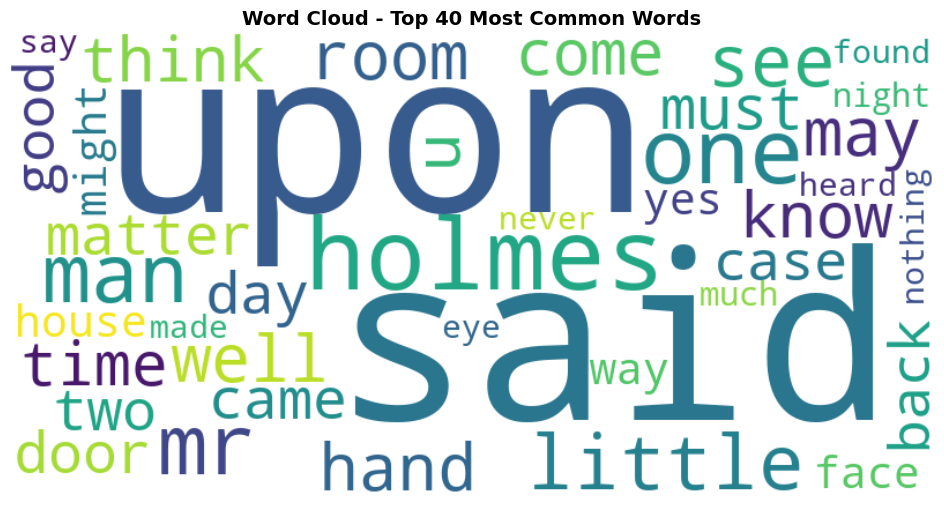

In [19]:
print("\n" + "="*70)
print("WORD FREQUENCY ANALYSIS (After Stopword Removal)")
print("="*70)

# Count word frequencies
word_counts = Counter(filtered_tokens)
top_40_words = word_counts.most_common(40)

# Create DataFrame
df_words = pd.DataFrame(top_40_words, columns=["Word", "Count"])

print("Top 40 most frequent words:")
display(df_words)

# Bar Chart
plt.figure(figsize=(14, 6))
plt.bar(df_words["Word"], df_words["Count"], 
        color="blue", edgecolor="black", alpha=0.7)
plt.xticks(rotation=75, ha='right')
plt.title("Top 40 Most Frequent Words (After Stopword Removal)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Word", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.tight_layout()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Word Cloud - All filtered words
wordcloud_all = WordCloud(width=800, height=400, background_color='white', 
                          collocations=False).generate(" ".join(filtered_tokens))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - All Frequent Words", fontsize=14, fontweight='bold')
plt.show()

# Word Cloud - Top 40 only
wordcloud_top40 = WordCloud(width=800, height=400, background_color='white', 
                            max_words=40, collocations=False).generate(" ".join(filtered_tokens))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_top40, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Top 40 Most Common Words", fontsize=14, fontweight='bold')
plt.show()

---

## 8. N-gram Analysis (Bigrams & Trigrams)

N-grams capture sequences of consecutive words, revealing common phrases and patterns in the text. Our `generate_ngrams()` function creates these sequences by sliding a window of size n across our token list. For bigrams (n=2), we get pairs like "sherlock holmes" or "dear watson". For trigrams (n=3), we get three-word phrases like "baker street london".

We count the top 20 most frequent bigrams and trigrams using `Counter`, then visualize them with horizontal bar charts. The charts are oriented horizontally because phrase labels can be long and are easier to read this way.

For the word clouds, we face a technical challenge: WordCloud splits on spaces, but our n-grams contain spaces. To solve this, we replace spaces within each n-gram with underscores (turning "sherlock holmes" into "sherlock_holmes"), then join all n-grams with spaces. This tricks the WordCloud into treating each n-gram as a single unit. We use different color schemes (plasma for bigrams, inferno for trigrams) to distinguish between the two visualizations. These n-gram analyses reveal characteristic phrases and expressions that define Conan Doyle's writing style.



N-GRAM ANALYSIS

Top 20 Bigrams:


,Bigram,Count
0,said holmes,112
1,sherlock holmes,97
2,mr holmes,71
3,st simon,40
4,could see,31
5,baker street,29
6,lord st,28
7,st clair,27
8,young lady,24
9,let us,22



Top 20 Trigrams:


,Trigram,Count
0,lord st simon,28
1,neville st clair,15
2,mr sherlock holmes,13
3,mr hosmer angel,13
4,mr neville st,9
5,mrs st clair,9
6,said sherlock holmes,8
7,dr grimesby roylott,8
8,red headed league,7
9,mr jabez wilson,7


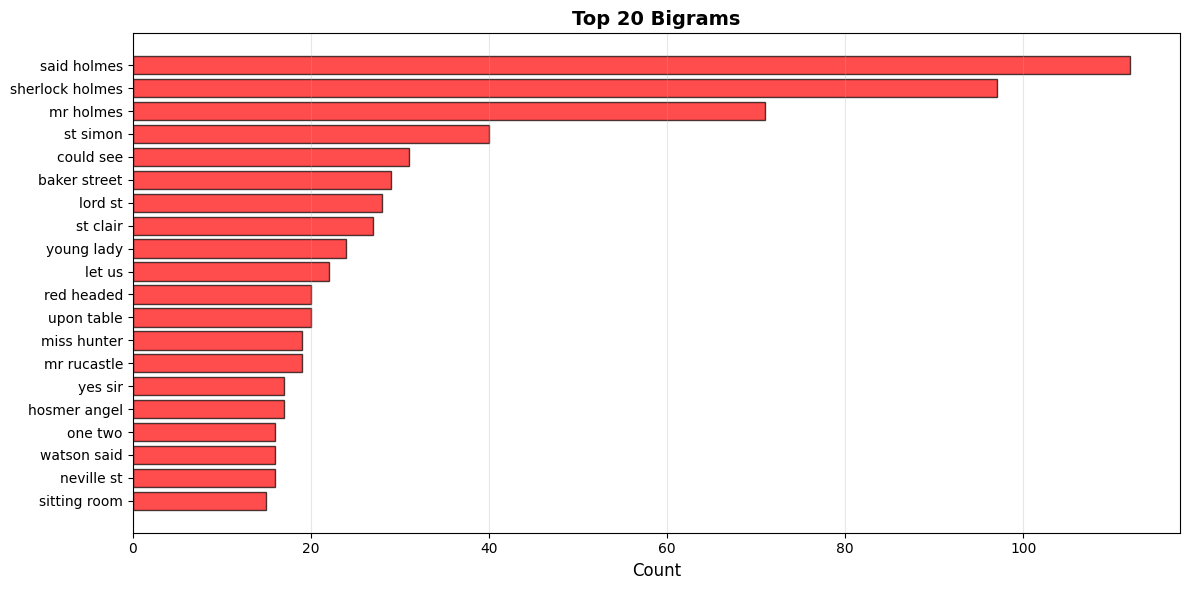

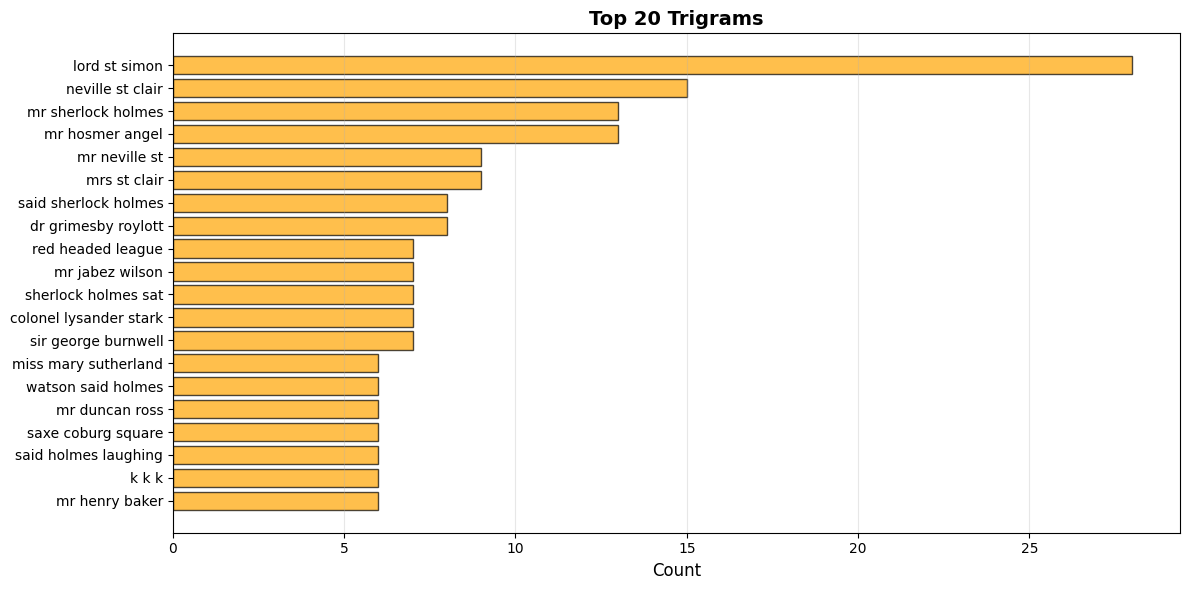

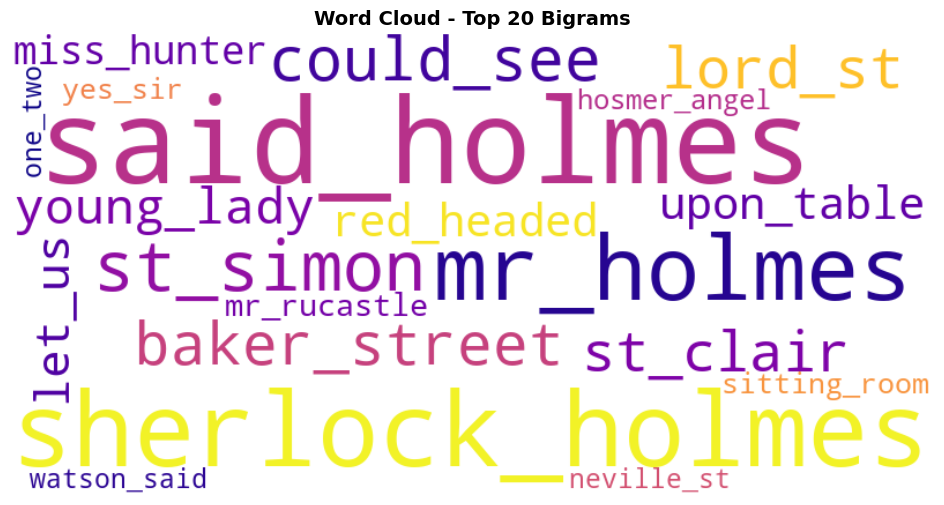

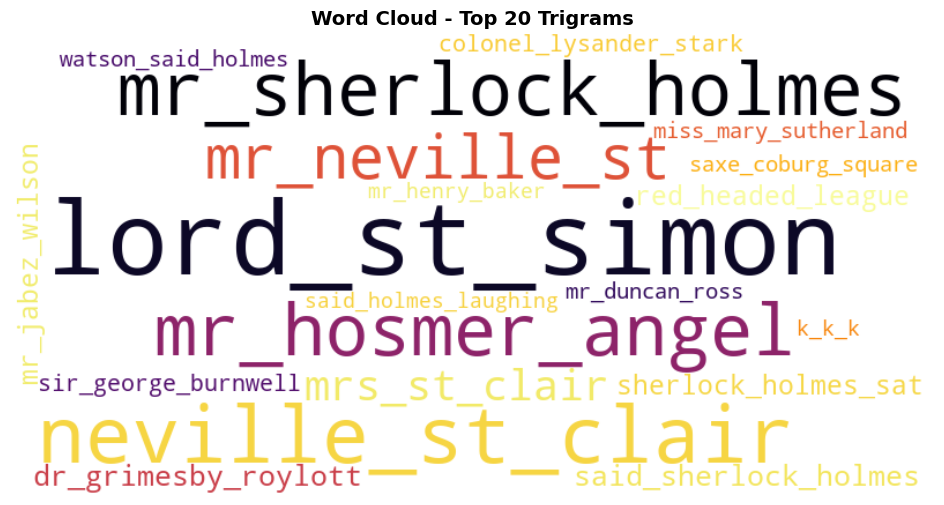

In [20]:
def generate_ngrams(tokens, n):
    """
    Generate n-grams from token list.
    
    Parameters:
    - tokens: list of words
    - n: size of n-gram (2 for bigrams, 3 for trigrams)
    
    Returns: list of n-grams as strings
    """
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens) - n + 1)]

print("\n" + "="*70)
print("N-GRAM ANALYSIS")
print("="*70)

# Generate bigrams and trigrams
bigrams = generate_ngrams(filtered_tokens, 2)
trigrams = generate_ngrams(filtered_tokens, 3)

# Count frequencies
bigram_counts = Counter(bigrams).most_common(20)
trigram_counts = Counter(trigrams).most_common(20)

# Create DataFrames
df_bigrams = pd.DataFrame(bigram_counts, columns=["Bigram", "Count"])
df_trigrams = pd.DataFrame(trigram_counts, columns=["Trigram", "Count"])

print("\nTop 20 Bigrams:")
display(df_bigrams)

print("\nTop 20 Trigrams:")
display(df_trigrams)

# Bigram Bar Chart
plt.figure(figsize=(12, 6))
plt.barh(df_bigrams["Bigram"], df_bigrams["Count"], 
         color="red", edgecolor="black", alpha=0.7)
plt.title("Top 20 Bigrams", fontsize=14, fontweight='bold')
plt.xlabel("Count", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Trigram Bar Chart
plt.figure(figsize=(12, 6))
plt.barh(df_trigrams["Trigram"], df_trigrams["Count"], 
         color="orange", edgecolor="black", alpha=0.7)
plt.title("Top 20 Trigrams", fontsize=14, fontweight='bold')
plt.xlabel("Count", fontsize=12)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Bigram Word Cloud
# Replace spaces with underscores to treat bigrams as single units
bgram_wc = " ".join([bg.replace(" ", "_") for bg in bigrams])

wc_bg = WordCloud(width=800, height=400, background_color='white', 
                  colormap="plasma", max_words=20, 
                  collocations=False).generate(bgram_wc)
plt.figure(figsize=(12, 6))
plt.imshow(wc_bg, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Top 20 Bigrams", fontsize=14, fontweight='bold')
plt.show()

# Trigram Word Cloud
# Replace spaces with underscores to treat trigrams as single units
tgram_wc = " ".join([tg.replace(" ", "_") for tg in trigrams])

wc_tg = WordCloud(width=800, height=400, background_color='white', 
                  colormap="inferno", max_words=20, 
                  collocations=False).generate(tgram_wc)
plt.figure(figsize=(12, 6))
plt.imshow(wc_tg, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Top 20 Trigrams", fontsize=14, fontweight='bold')
plt.show()


---

## 9. Sentence Structure Analysis (Bonus Challenge)

For the bonus challenge, we analyze sentence-level patterns using the original unmodified text (since we need punctuation to identify sentences). We split the text on sentence-ending punctuation (periods, exclamation marks, question marks) using regular expressions.

We calculate the average number of words per sentence by tokenizing each sentence and counting words. We also identify the most common sentence starters by extracting the first word of each sentence and counting frequencies. This reveals Conan Doyle's stylistic preferences : does he often start with "The", "I", "He", etc.?

The sentence length distribution histogram shows how Conan Doyle varies his sentence structure. A narrow distribution suggests consistent sentence length, while a wide distribution indicates varied pacing. We overlay the average sentence length as a red dashed line for reference. This analysis gives insights into the author's writing rhythm and complexity.



SENTENCE STRUCTURE ANALYSIS (Bonus Challenge)
Total sentences: 7515

Average words per sentence: 14.48

Top 10 most common sentence starters:
  'I': 578 times
  'It': 280 times
  'The': 233 times
  'He': 188 times
  'You': 140 times
  'There': 119 times
  'But': 102 times
  'Holmes': 97 times
  'And': 87 times
  'Then': 77 times


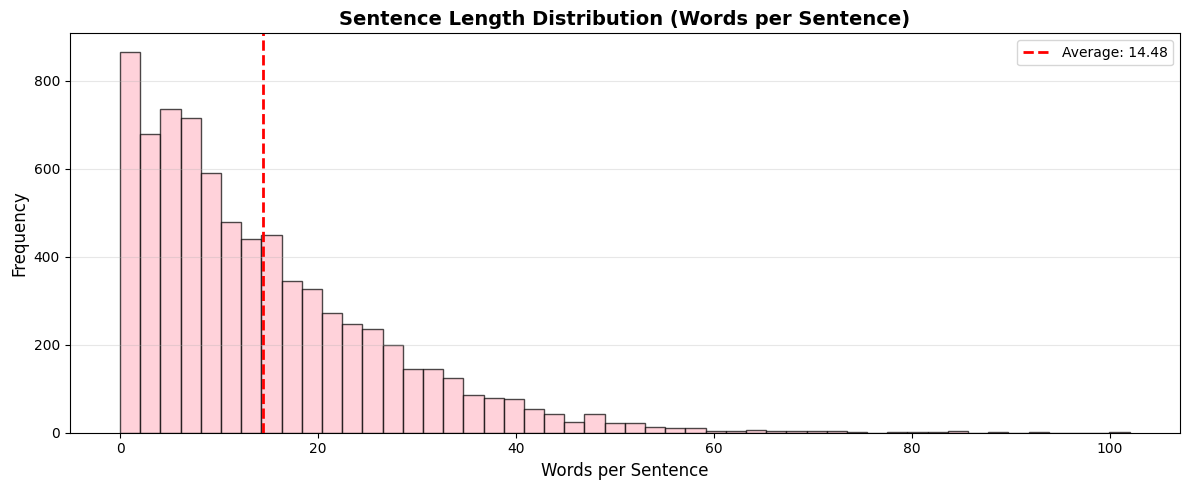

In [21]:
print("\n" + "="*70)
print("SENTENCE STRUCTURE ANALYSIS (Bonus Challenge)")
print("="*70)

# Split into sentences using punctuation marks
sentences = re.split(r"[.!?]+", original_text)
sentences = [s.strip() for s in sentences if len(s.strip()) > 0]

print(f"Total sentences: {len(sentences)}")

# Calculate words per sentence
sentence_lengths = [len(re.findall(r"\b[a-zA-Z']+\b", s)) for s in sentences]
avg_sentence_length = sum(sentence_lengths) / len(sentence_lengths)

# Find common sentence starters
starters = [re.findall(r"^[A-Za-z']+", s)[0].lower() 
            for s in sentences if re.findall(r"^[A-Za-z']+", s)]
starter_counts = Counter(starters).most_common(10)

print(f"\nAverage words per sentence: {round(avg_sentence_length, 2)}")
print(f"\nTop 10 most common sentence starters:")
for starter, count in starter_counts:
    print(f"  '{starter.capitalize()}': {count} times")

# Plot sentence length distribution
plt.figure(figsize=(12, 5))
plt.hist(sentence_lengths, bins=50, edgecolor="black", 
         color="pink", alpha=0.7)
plt.title("Sentence Length Distribution (Words per Sentence)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Words per Sentence", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.axvline(avg_sentence_length, color='red', linestyle='--', 
            linewidth=2, label=f'Average: {round(avg_sentence_length, 2)}')
plt.legend()
plt.tight_layout()
plt.show()

---

## 10. Complexity Analysis

The complexities depend on various factors: the length of the original text (T), the number of tokens/words (n), the number of unique words (u), and the number of sentences (s).

- **Text Cleaning and Preprocessing:**  
Our `text_clean()` function processes the entire text character-by-character, performing lowercase conversion, removing unwanted characters with regex, and normalizing whitespace. The time complexity is **O(T)** where T is the length of the original text in characters, since we make several linear passes through the text. The space complexity is also **O(T)** because we create a cleaned copy of the entire text string.

- **Tokenization:**  
Our custom tokenization function iterates through every character in the cleaned text exactly once, building words character-by-character until encountering spaces. This gives us **O(T)** time complexity where T is the text length. The space complexity is **O(n)** where n is the number of tokens produced, as we store all tokens in a list. In the worst case where every character is a separate word, n could approach T.

- **Stopword Removal:**  
Filtering stopwords requires checking each token against our stopword set. For each of the n tokens, we perform an O(1) lookup in the stopword set (since sets use hash tables). This gives us **O(n)** time complexity where n is the number of tokens. The space complexity is **O(n)** for storing the filtered token list, plus **O(w)** for the stopword set where w is the number of stopwords.

- **Letter Frequency Analysis:**  
We extract all letters from the cleaned text using regex, which scans through the entire text in **O(T)** time. Counting letter frequencies with `Counter` takes **O(L)** time where L is the number of letters found (which is ≤ T). Creating the DataFrame and calculating proportions involves 26 operations (one per letter), which is **O(1)** since it's constant. Overall time complexity is **O(T)**. Space complexity is **O(1)** since we only store counts for 26 letters regardless of text size.

- **Word Frequency Analysis:**  
Counting word frequencies requires iterating through all filtered tokens and updating counters. Using Python's `Counter`, this takes **O(n)** time where n is the number of filtered tokens. Extracting the top 40 words is effectively **O(n)**. Space complexity is **O(u)** where u is the number of unique words, as the Counter must store all unique word frequencies. Creating visualizations (bar charts and word clouds) processes at most the top 40 words, which is **O(1)** relative to input size.

- **N-gram Generation (Bigrams and Trigrams):**  
Our `generate_ngrams()` function slides a window of size k across the token list, creating n-k+1 n-grams from n tokens. For each position, we join k consecutive words into a string, which takes **O(k × L)** time where L is the average word length. For bigrams (k=2) and trigrams (k=3), this gives us **O(n)** time complexity since k is constant. Space complexity is **O(n)** because we potentially generate approximately n bigrams and n trigrams, each stored as a string.

- **N-gram Frequency Counting:**  
Counting bigram and trigram frequencies works identically to word frequency counting. For m n-grams, counting takes **O(m)** time and extracting top 20 is **O(m)** since 20 is constant. Space complexity is **O(m)** in the worst case where all n-grams are unique. For word clouds, we additionally process the n-grams to replace spaces with underscores, which takes **O(m × k)** time where k is the n-gram size, simplifying to **O(m)** for constant k.

- **Sentence Structure Analysis:**  
Splitting text into sentences using regex punctuation patterns scans the original text once, giving **O(T)** time complexity. Calculating words per sentence requires tokenizing each of s sentences, which takes **O(T)** total time across all sentences. Finding sentence starters extracts the first word from each sentence in **O(s)** time. The histogram computation processes s sentence lengths in **O(s)** time. Overall time complexity is **O(T + s)**, which simplifies to **O(T)** since s ≤ T. Space complexity is **O(s)** for storing all sentences and their length statistics.


**Overall Pipeline Efficiency:**  
Our complete analysis pipeline is dominated by operations that scale linearly with text size. The preprocessing and tokenization stages are **O(T)** where T is the text length. The counting and frequency analysis stages are **O(n)** where n is the number of tokens. Since n ≤ T (tokens are subsequences of the text), the overall time complexity is **O(T + n)**, which simplifies to **O(T)**. 

The space complexity is primarily **O(n)** for storing tokens and their various transformations (filtered tokens, n-grams, etc.). We also use **O(u)** space for unique word counts where u ≤ n. In practical terms, our implementation efficiently handles texts of 50,000+ words by making single linear passes through the data and using efficient data structures like Counter (hash-based) for frequency counting.

The analysis demonstrates good algorithmic efficiency, we avoid nested loops and quadratic operations, ensuring that our pipeline scales linearly with input size. This makes it suitable for analyzing even longer texts like complete novels without performance concerns.

---

## 11. Interpretation of Distributions

- The distribution of letters is multimodal, with ‘e’ being the most frequently used letter. ‘a’, ‘o’, and ‘t’ were the second most frequent. The least frequent letters are ‘j’, ‘q’, ‘x’, and ‘z’ which appear rarely.

- The distribution of words is unimodal. The most frequent word is 'said' with the second and third most frequent words being 'upon' and 'holmes'. The distribution flattens out as it continues to the right with the least frequent words being very similar in frequency. Some of these words include, 'never', 'nothing', and 'found'.

- The distribution of bigrams and trigrams is very interesting. The top three most frequent bigrams include 'holmes.' Whereas only the third most frequent trigram contains 'holmes'. Both of these distributions are unimodal. Additionally the most frequent bigram occurs over 100 times whereas the most frequent trigram appears barely over 25 times.

- The distribution of the sentence length or words per sentence is also unimodal. The average amount of words per sentence is 14.48. The unimodal distribution is right-skewed, this indicates that most sentences contain fewer words with a tail extending to the right showing few sentences with larger amounts of words.

---

## 12. Testing the Text Analysis Pipeline

We validate our text analysis implementation using tests to ensure each component works correctly.

In [22]:
print("\n" + "="*70)
print("TEXT PROCESSING TESTS")
print("="*70)

# Configure test text that has letters, numbers, punctuation,
# and special characters to test word analysis functions
test_text = (
    "This is test text... Here is the alphabet: \n"
    "The quick brown fox jumps over the lazy dog. "
    "Also $!@ characters, numbers 463 and Roman numerals IX. and iv.. \n"
    "The ever lazy dog can count to 149 with extra spaces   - see? The end."
)
original_test_text = test_text

print("\nOriginal Test Text:")
print("-" * 70)
print(test_text)

# 1️⃣ Clean test text

print("\nSTEP 1: TEXT CLEANING")
cleaned_text = text_clean(test_text)

print("\nOriginal Text (Preview):")
print(original_test_text[:150] + "...")
print("\nCleaned Text (Preview):")
print(cleaned_text[:150] + "...")

# 2️⃣ Tokenize test text
print("\n" + "="*70)
print("STEP 2: TOKENIZATION")
print("="*70)
test_tokens = tokenize(cleaned_text)
print(f"Total tokens: {len(test_tokens)}")
print("Sample tokens (first 15):")
print(test_tokens[:15])

# 3️⃣ Filter stopwords
print("\n" + "="*70)
print("STEP 3: STOPWORD REMOVAL")
print("="*70)
filtered_test_tokens = filter_stopwords(test_tokens)
print(f"\nFiltered token count: {len(filtered_test_tokens)}")
print("Sample filtered tokens (first 15):")
print(filtered_test_tokens[:15])

# 4️⃣ Generate n-grams
print("\n" + "="*70)
print("STEP 4: N-GRAM GENERATION")
print("="*70)
test_bigrams = generate_ngrams(filtered_test_tokens, 2)
test_trigrams = generate_ngrams(filtered_test_tokens, 3)

print("\nSample Bigrams (first 10):")
print(test_bigrams[:10])

print("\nSample Trigrams (first 10):")
print(test_trigrams[:10])

# 5️⃣ Frequency Summary
print("\n" + "="*70)
print("STEP 5: FREQUENCY ANALYSIS")
print("="*70)
bigram_counts = Counter(test_bigrams).most_common(5)
trigram_counts = Counter(test_trigrams).most_common(5)

print("\nTop 5 Bigrams:")
for bg, count in bigram_counts:
    print(f"{bg:<40} {count}")

print("\nTop 5 Trigrams:")
for tg, count in trigram_counts:
    print(f"{tg:<40} {count}")

print("\n" + "="*70)
print("TEST COMPLETED SUCCESSFULLY")
print("="*70)



TEXT PROCESSING TESTS

Original Test Text:
----------------------------------------------------------------------
This is test text... Here is the alphabet: 
The quick brown fox jumps over the lazy dog. Also $!@ characters, numbers 463 and Roman numerals IX. and iv.. 
The ever lazy dog can count to 149 with extra spaces   - see? The end.

STEP 1: TEXT CLEANING

PREPROCESSING STEPS
Original text length: 225 characters
No Project Gutenberg markers ('***') found; skipping header/footer removal
Removed Roman numerals
Removed punctuation, digits, special characters (kept apostrophes)
Normalized whitespace
Cleaned text length: 190 characters

Original Text (Preview):
This is test text... Here is the alphabet: 
The quick brown fox jumps over the lazy dog. Also $!@ characters, numbers 463 and Roman numerals IX. and i...

Cleaned Text (Preview):
this is test text here is the alphabet the quick brown fox jumps over the lazy dog also characters numbers and roman numerals and the ever lazy dog ca